In [1]:
!git clone https://github.com/ssingh1997/CV_Snap_Filter.git

fatal: destination path 'CV_Snap_Filter' already exists and is not an empty directory.


In [2]:
import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import cv2
import math
from PIL import Image
import torch
import torchvision.transforms as T

/Users/henrytse/opt/anaconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_zip = './CV_Snap_Filter/facial-keypoints-detection.zip'
with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
training_zip = './training.zip'
test_zip = './test.zip'

In [5]:
with zipfile.ZipFile(training_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

In [6]:
with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall('.')

In [7]:
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')
lookup_id = pd.read_csv('IdLookupTable.csv')

In [8]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [9]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [10]:
lookup_id.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [12]:
train_data.dropna(inplace=True)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [14]:
imag = []
for i in range(0,train_data.shape[0]):
    if i in train_data.index:
      img = train_data['Image'][i].split(' ')
      img = ['0' if x == '' else x for x in img]
      imag.append(img)
    else:
      pass

In [15]:
test_imag = []
for i in range(0,test_data.shape[0]):
    if i in test_data.index:
      test_img = test_data['Image'][i].split(' ')
      test_img = ['0' if x == '' else x for x in test_img]
      test_imag.append(test_img)
    else:
      pass

In [16]:
img_arr = np.array(imag, dtype='float')
x_train = img_arr.reshape(-1, 96, 96, 1)

In [17]:
test_img_arr = np.array(test_imag, dtype='float')
x_test = test_img_arr.reshape(-1, 96, 96, 1)

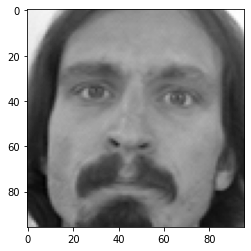

In [18]:
plt.imshow(x_train[0].reshape(96,96),cmap='gray')
plt.show()

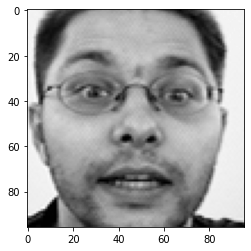

In [19]:
plt.imshow(x_test[0].reshape(96,96),cmap='gray')
plt.show()

In [20]:
train_data.T[0]['left_eye_center_x']

66.0335639098

In [21]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [22]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,2272,2273,2274,2275,2276,2277,2278,2281,2282,2283
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301,69.680748,64.131866,67.468893,65.80288,64.121231,...,66.827593,64.126581,63.738273,64.644616,64.383649,67.180378,65.72449,68.430866,64.15218,66.683755
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261,39.968748,34.29004,39.413452,34.7552,36.740308,...,30.620361,33.096095,34.407682,34.280084,35.104561,35.816373,36.30102,38.651975,30.691592,34.483429
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481,29.183551,29.578953,29.355961,27.47584,29.468923,...,25.111875,25.716503,26.854206,28.284307,30.424912,33.239956,25.377551,28.895857,27.000898,30.78449
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032,37.563364,33.13804,39.621717,36.1856,38.390154,...,33.298484,38.118015,39.145823,38.586911,33.399298,34.921932,37.311224,37.617027,40.868082,38.578939
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589,62.864299,57.797154,59.554951,58.65216,58.620923,...,58.383626,57.887226,56.297606,57.75651,57.814386,59.347973,58.530612,61.65935,56.505624,59.255347
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261,40.169271,35.15404,40.454773,37.32928,37.840615,...,33.172455,34.952683,36.662645,36.588318,37.715088,37.000904,37.739796,40.100902,34.126963,36.065143
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926,76.898243,69.026577,75.591612,72.95296,71.272,...,77.104027,73.318216,72.467827,73.673751,72.551228,72.667896,74.44898,75.586792,73.436776,73.942694
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466,41.171888,34.29004,40.038245,35.89952,37.290338,...,32.544829,32.913479,34.297713,33.584799,35.841403,37.0976,37.52551,40.219182,28.556335,34.624653
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238,36.401047,34.761664,37.478214,36.3424,36.344615,...,33.555842,34.177677,35.574892,36.334975,40.193333,39.404349,33.55102,37.665118,34.746122,37.478531
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852,39.367626,33.71404,40.454773,37.0432,39.490462,...,34.495763,38.483245,39.884864,39.375088,36.578245,36.589944,38.107143,39.087245,40.506939,39.398041


In [23]:
def get_landmarks(train_data):
  landmarks_dict = {}
  k=0
  for i in tqdm(range(train_data.shape[0])):
    if i in train_data.index:
      landmarks_dict[k] = {
          'left eye center': (train_data['left_eye_center_x'][i], train_data['left_eye_center_y'][i]),
          'right eye center': (train_data['right_eye_center_x'][i], train_data['right_eye_center_y'][i]),

          'left eye inner corner': (train_data['left_eye_inner_corner_x'][i], train_data['left_eye_inner_corner_y'][i]),
          'left eye outer corner': (train_data['left_eye_outer_corner_x'][i], train_data['left_eye_outer_corner_y'][i]),

          'right eye inner corner': (train_data['right_eye_inner_corner_x'][i], train_data['right_eye_inner_corner_y'][i]),
          'right eye outer corner': (train_data['right_eye_outer_corner_x'][i], train_data['right_eye_outer_corner_y'][i]),

          'left eyebrow inner end': (train_data['left_eyebrow_inner_end_x'][i], train_data['left_eyebrow_inner_end_y'][i]),
          'left eyebrow outer end': (train_data['left_eyebrow_outer_end_x'][i], train_data['left_eyebrow_outer_end_y'][i]),

          'right eyebrow inner end': (train_data['right_eyebrow_inner_end_x'][i], train_data['right_eyebrow_inner_end_y'][i]),
          'right eyebrow outer end': (train_data['right_eyebrow_outer_end_x'][i], train_data['right_eyebrow_outer_end_y'][i]),

          'nose tip': (train_data['nose_tip_x'][i], train_data['nose_tip_y'][i]),

          'mouth left corner': (train_data['mouth_left_corner_x'][i], train_data['mouth_left_corner_y'][i]),
          'mouth right corner': (train_data['mouth_right_corner_x'][i], train_data['mouth_right_corner_y'][i]),

          'mouth center top lip': (train_data['mouth_center_top_lip_x'][i], train_data['mouth_center_top_lip_y'][i]),
          'mouth center bottom lip': (train_data['mouth_center_bottom_lip_x'][i], train_data['mouth_center_bottom_lip_y'][i]),
      }
      k+=1
    else:
      pass

  return landmarks_dict

In [24]:
landmarks_dict = get_landmarks(train_data)

100%|█████████████████████████████████████| 2140/2140 [00:00<00:00, 9208.19it/s]


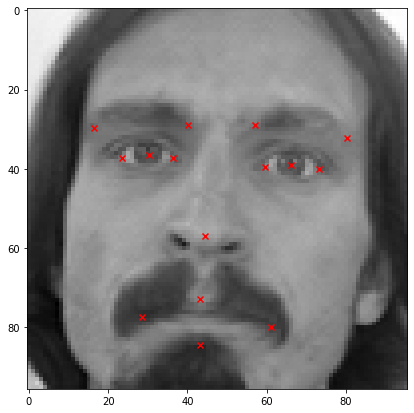

In [25]:
plt.figure(figsize=(7, 7))
plt.imshow(x_train[0].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[0].values():
  xs.append(value[0])
  ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

In [26]:
training = train_data.drop('Image',axis = 1)

y_train = []
for i in range(0,len(training)):
    if i in train_data.index:
        y = training.iloc[i,:]

        y_train.append(y)
y_train = np.array(y_train,dtype = 'float')

In [27]:
def rotation_helper(angle):
    if(angle>=0 and angle <=90):
        x=angle*(96/90)
        if(angle>=0 and angle<=45):
            y=-1*angle*(24/45)
        else:
            y=(angle-45)*(24/45)-24
    elif(angle>=91 and angle<=180):
        y=(angle-90)*(96/90)
        if(angle>=91 and angle<=135):
            x=(angle-90)*(24/45)+96
        else:
            x=-1*(angle-135)*(24/45)+120
    elif(angle>=181 and angle<=270):
        x=-1*(angle-180)*(96/90)+96
        if(angle>=181 and angle<=225):
            y=(angle-180)*(24/45)+96
        else:
            y=-1*(angle-225)*(24/45)+120
    else:
        y=-1*(angle-270)*(96/90)+96
        if(angle>=271 and angle<=315):
            x=-1*(angle-270)*(24/45)
        else:
            x=(angle-315)*(24/45)-24
    return x,y

In [28]:
def affine_transform(image,landmark):
    rotation=random.randint(0,360)
    translation_x=random.randint(1,5)
    translation_y=random.randint(1,5)
    scaling = 1
#     print(rotation)
#     print(translation_x)
#     print(translation_y)
#     print(scaling)
    
    new_img=T.functional.affine(image,angle=rotation,scale=scaling,shear=0,translate=[translation_x,translation_y])
    delta_x,delta_y=rotation_helper(rotation)
#     print(delta_x)
#     print(delta_y)
    new_landmark={}
    rotation=rotation*(math.pi/180)
    k=list(landmark.keys())
    j=0
    for i in list(landmark.values()):
        new_x=i[0]*math.cos(rotation)-i[1]*math.sin(rotation)+translation_x+delta_x
        new_y=i[0]*math.sin(rotation)+i[1]*math.cos(rotation)+translation_y+delta_y
        v=(new_x,new_y)
        key_dict=k[j]
        new_landmark[key_dict]=v
        j+=1
    return new_img,new_landmark

In [29]:
def data_augmentation_transforms(images,landmarks):
    new_images=[]
    k=len(landmarks_dict)
    for i in range(images.shape[0]):
        for j in range(2):
            orig_img=Image.fromarray(images[i].reshape(96,96))
            new_img,new_landmark=affine_transform(orig_img,landmarks[i])
            new_images.append(np.array(new_img).reshape(96,96,1))
            landmarks[k]=new_landmark
            k+=1
    return new_images,landmarks

In [30]:
new_images1,new_landmarks1=data_augmentation_transforms(x_train,landmarks_dict)

In [31]:
def data_augmentation_brightness(images,landmarks):
    new_images=[]
    k=len(landmarks_dict)
    for i in range(images.shape[0]):
        orig_img=Image.fromarray(images[i].reshape(96,96))
        orig_img=orig_img.convert('RGB')
        new_img1=T.functional.autocontrast(orig_img)
        new_img2=T.functional.adjust_sharpness(orig_img,2)
        new_img1=new_img1.convert('L')
        new_img2=new_img2.convert('L')
        new_images.append(np.array(new_img1).reshape(96,96,1))
        landmarks[k]=landmarks[i]
        k+=1
        new_images.append(np.array(new_img2).reshape(96,96,1))
        landmarks[k]=landmarks[i]
        k+=1
    return new_images,landmarks

In [32]:
new_images2,new_landmarks2=data_augmentation_brightness(x_train,landmarks_dict)

In [33]:
new_images1=np.array(new_images1)
x_train=np.concatenate((x_train,new_images1))
new_images2=np.array(new_images2)
x_train=np.concatenate((x_train,new_images2))

In [34]:
#New training data after augmentation
x_train.shape

(10130, 96, 96, 1)

In [35]:
#New landmarks after augmentation
len(landmarks_dict)

10130

15


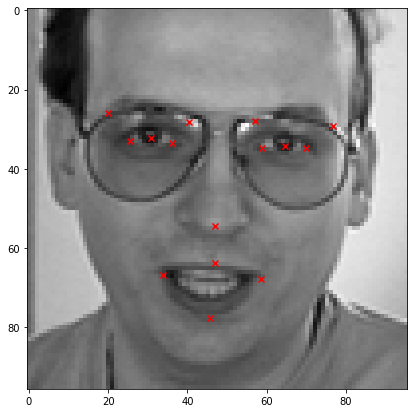

In [36]:
#Original Image in the intial training data
plt.figure(figsize=(7, 7))
plt.imshow(x_train[36].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[36].values():
    xs.append(value[0])
    ys.append(value[1])
print(len(xs))
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

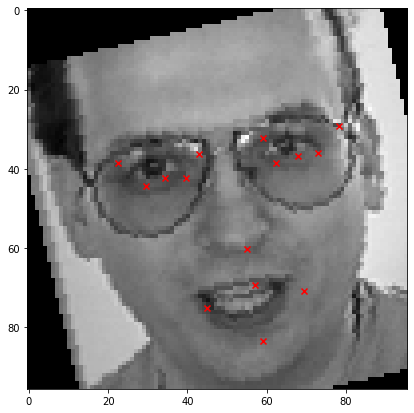

In [37]:
#Transformed image from the original image with landmarks transformed along with the image
#Test for new affine transformed images
#Checking whether landmarks are properly applied for the transformed images
plt.figure(figsize=(7, 7))
plt.imshow(x_train[2099].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[2099].values():
    xs.append(value[0])
    ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

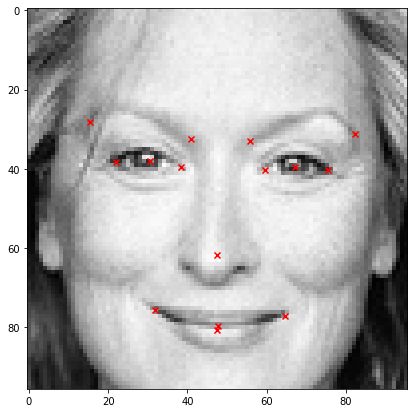

In [38]:
#Original Image in the intial training data
plt.figure(figsize=(7, 7))
plt.imshow(x_train[1990].reshape(96,96),cmap='gray')

xs = []
ys = []
for value in landmarks_dict[1990].values():
    xs.append(value[0])
    ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

In [39]:
print(x_train[10059].reshape(96,96).astype('uint8'))
test_img = x_train[10059].reshape(96,96).astype('uint8')
test_img_rbg = cv2.cvtColor(test_img,cv2.COLOR_GRAY2RGBA)

[[110 115  94 ... 164 202 202]
 [ 99 112 144 ... 120 175 197]
 [ 95 109 115 ... 137 144 160]
 ...
 [ 75  34  20 ...  51  10  57]
 [ 83  40  20 ...  17  24  72]
 [ 76  52  30 ...  28  39  71]]


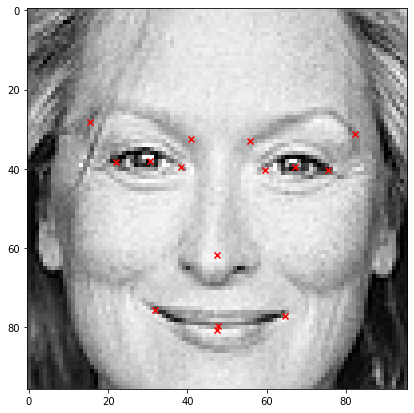

In [40]:
#Test for new sharpness and contrast adjusted images
plt.figure(figsize=(7, 7))
plt.imshow(test_img_rbg,cmap='gray')

xs = []
ys = []
for value in landmarks_dict[10059].values():
  xs.append(value[0])
  ys.append(value[1])
plt.scatter(xs, ys, marker='x', color='red')
plt.show()

In [41]:
#Depending on the filter, we need to use certain landmark data to figure out the scale of our image
def img_scaling(fil_type, x_land, y_land):
    w = 0
    h = 0
    if(fil_type == 'nose'):
        #We will use the nose, upperlip, and left corner of the lip to determine the size of this filter
        
        #left lip - right lip
        w = abs(x_land[11]-x_land[12])
        
        #nose tip - upper lip
        h = abs(y_land[10]-y[13])*1.5
    return w,h

In [42]:
#testing img_scaling
for value in landmarks_dict[1990].values():
    xs.append(value[0])
    ys.append(value[1])
wt,ht = img_scaling('nose', xs, ys)
print(wt,ht)

32.981733021400004 47.76980185709999


In [43]:
#for using images without scaling them down
def im_setup2(img_path, scale_factor):
    im = cv2.imread(img_path, -1)
    (h, w) = im.shape[:2]
    im = cv2.resize(im, (w//scale_factor,h//scale_factor), interpolation = cv2.INTER_AREA)
    im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype('uint8')
    RGB_im = cv2.cvtColor(im_uint8, cv2.COLOR_BGR2RGBA)
    return RGB_im

In [44]:
#for using images without scaling them down
def im_setup(img_path, width, height):
    im = cv2.imread(img_path, -1)
    (h, w) = im.shape[:2]
    im = cv2.resize(im, (width,height), interpolation = cv2.INTER_AREA)
    im_uint8 = ((im - np.min(im)) * (1/(np.max(im) - np.min(im)) * 255)).astype('uint8')
    RGB_im = cv2.cvtColor(im_uint8, cv2.COLOR_BGR2RGBA)
    return RGB_im

In [45]:
def createLandMarks(img_type, width,height ,scale_factor):
    #landmarks, to be hard set on certain filters
    xs = []
    ys = []
    if(img_type == 'nose'):
        #main landmark will correspond to the nose area, this should go onto the middle of the nose
        xs.append(width//2)
        #ys.append(height//2 - 20//scale_factor)
        ys.append(height *.4)
        
        #left lip
        xs.append(.25 * width )
        ys.append(height* .7 )
        
        #right lip 
        xs.append(width - .25 * width )
        ys.append(height* .7 )
        
        #upper lip
        #xs.append(width//2 )
        #ys.append(height* .7 )
    elif(img_type == 'glasses'):
        #left brow
        xs.append(width * .15)
        ys.append(height * .25 )
        
        #right brow
        xs.append(width * .85)
        ys.append(height * .25 )
        
        #nose
        xs.append(width * .5)
        ys.append(height)
        
    elif(img_type == 'eyes'):
        #left brow
        xs.append(width * .05)
        ys.append(height * .2 )
        
        #outer eye left
        xs.append(width * .1)
        ys.append(height * .63 )
        
        #inner eye left
        xs.append(width * .36)
        ys.append(height * .63)
        
        #inner eye right
        xs.append(width * .64)
        ys.append(height * .63)
        
        #outer eye right 
        xs.append(width * .9)
        ys.append(height * .63 )
        
        #right brow
        xs.append(width * .95)
        ys.append(height * .2 )
    return xs,ys

In [46]:
#Open the Nose Filter Image
sf = 1 #scale_factor
img_nose = im_setup('./Filter_Images/Luigi_Stache.png', 96,96)
(h, w) = img_nose.shape[:2]
img_type = 'nose'
nose_xs,nose_ys = createLandMarks(img_type, w,h,sf)

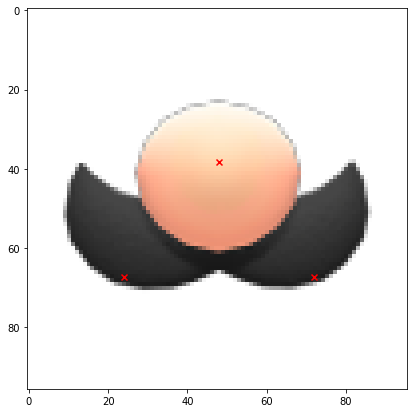

In [47]:
#print(img_nose)
plt.figure(figsize=(7, 7))
plt.imshow(img_nose, cmap='gray')
plt.scatter(nose_xs, nose_ys, marker='x', color='red')
plt.show()



In [48]:
#Open the Eye glasses Filter image
sf = 1 #scale_factor
img_glasses = im_setup('./Filter_Images/HP_Glasses.png',96,96)
(h, w) = img_glasses.shape[:2]
img_type = 'glasses'

gla_xs,gla_ys = createLandMarks(img_type, w,h,sf)


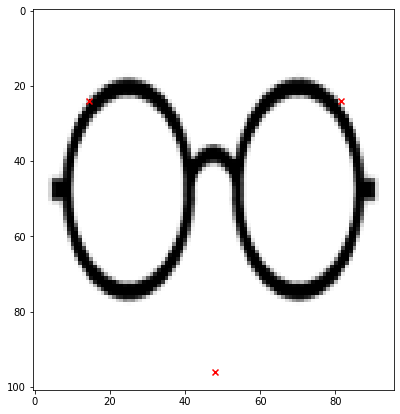

In [49]:
plt.figure(figsize=(7, 7))
plt.imshow(img_glasses, cmap='gray')
plt.scatter(gla_xs, gla_ys, marker='x', color='red')
plt.show()


In [50]:
#testing img_scaling
xs = []
ys = []
for value in landmarks_dict[1990].values():
    xs.append(value[0])
    ys.append(value[1])


In [51]:
nose_coords = np.float32( [(nose_xs[0],nose_ys[0]),(nose_xs[1],nose_ys[1]),(nose_xs[2],nose_ys[2]) ] )
val_coords = np.float32([(xs[10],ys[10]),(xs[11],ys[11]),(xs[12],ys[12])])

In [52]:
#need to come up with our own affine transform and warp affine functions
trans = cv2.getAffineTransform( nose_coords, val_coords )
print(trans)

[[-6.87119524e-01  3.13557238e-02  7.91406763e+01]
 [-2.90398598e-02  5.05985102e-01  4.37982749e+01]]


In [53]:
new_nose_img = cv2.warpAffine(img_nose, trans, (96, 96))

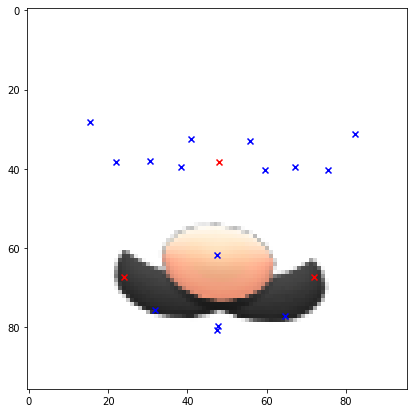

In [54]:
plt.figure(figsize=(7, 7))
plt.imshow(new_nose_img, cmap='gray')
plt.scatter(nose_xs, nose_ys, marker='x', color='red')
plt.scatter(xs, ys, marker='x', color='blue')
plt.show()


In [55]:
glasses_coords = np.float32( [(gla_xs[0],gla_ys[0]),(gla_xs[1],gla_ys[1]),(gla_xs[2],gla_ys[2]) ] )
val_coords2 = np.float32([(xs[7],ys[7]),(xs[9],ys[9]),(xs[10],ys[10])])

In [56]:
trans2 = cv2.getAffineTransform( glasses_coords, val_coords2 )
new_glasses_img = cv2.warpAffine(img_glasses, trans2, (96, 96))

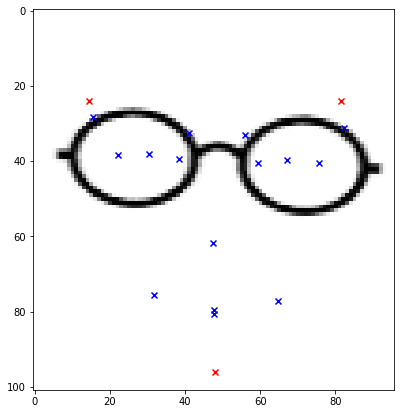

In [57]:
plt.figure(figsize=(7, 7))
plt.imshow(new_glasses_img, cmap='gray')
plt.scatter(gla_xs, gla_ys, marker='x', color='red')
plt.scatter(xs, ys, marker='x', color='blue')
plt.show()


In [58]:
#take in two sets of 3 points and figure out the affine matrix
class InvalidArraySizes(Exception):
    pass
def affine_transform_mat(sor,dest):
    #errors that could be defined 
    outMat = [[0,0,0],[0,0,0]]
    b = []
    A = []
    try:
        if(len(sor) != len(dest)): #c1 and c2 must have the same amount of points
            raise InvalidArraySizes('There must be the same amount of points in both arrays')
        if(len(sor) < 3):
            raise InvalidArraySizes('source array must have a size of 3 or more')
        if(len(dest) < 3):
            raise InvalidArraySizes('destination array must have a size of 3 or more')
    except InvalidArraySizes as e: 
        print("Error",e)
        return 0
    #setup matricies for Least Squares Error
    for i in range(0, len(sor)):
        #set up b
        b.append([dest[i][0]])
        b.append([dest[i][1]])
        
        #we can assume sor and dest have the same number of points, so set up A here as well
        #format: [xi,yi,1,0,0,0], [0,0,0,xi,yi,1]
        A.append([sor[i][0],sor[i][1],1,0,0,0])
        A.append([0,0,0,sor[i][0],sor[i][1],1])
    b_np = np.array(b)
    A_np = np.array(A)
    #Least Likely Square Equation
    #Equation: affine vars = (A^t * A)^-1 * A^t  * B
    
    A_trans = np.transpose(A_np)
    inter = np.matmul(A_trans,A_np)
    inverse = np.linalg.inv(inter)
    final = np.matmul(np.matmul(inverse,A_trans),b_np).reshape(2,3)
    
    
    
    return final



In [59]:
trans_exp = affine_transform_mat(nose_coords,val_coords)
print(trans_exp )

[[-6.87119524e-01  3.13557238e-02  7.91406763e+01]
 [-2.90398598e-02  5.05985102e-01  4.37982749e+01]]


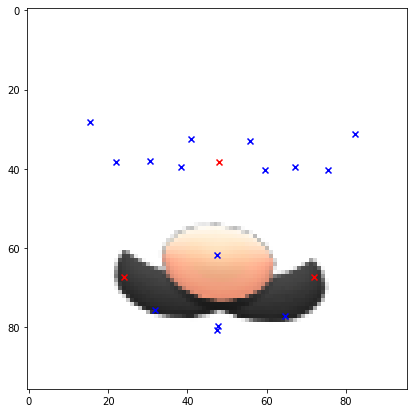

In [60]:
new_nose2_img = cv2.warpAffine(img_nose, trans_exp, (96, 96))
plt.figure(figsize=(7, 7))
plt.imshow(new_nose2_img, cmap='gray')
plt.scatter(nose_xs, nose_ys, marker='x', color='red')
plt.scatter(xs, ys, marker='x', color='blue')
plt.show()

In [61]:
#Open the Nose Filter Image
sf = 1 #scale_factor
img_eyes = im_setup('./Filter_Images/Eyes.png', 96,96)
(h, w) = img_eyes.shape[:2]
img_type = 'eyes'
eyes_xs,eyes_ys = createLandMarks(img_type, w,h,sf)

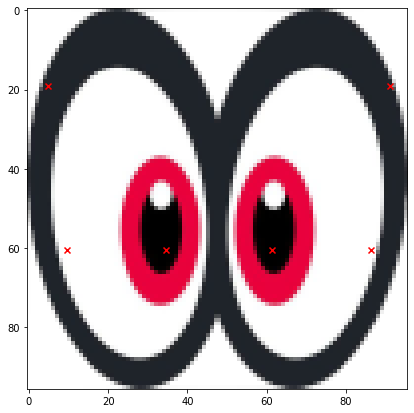

In [62]:
plt.figure(figsize=(7, 7))
plt.imshow(img_eyes, cmap='gray')
plt.scatter(eyes_xs, eyes_ys, marker='x', color='red')
plt.show()

In [63]:
eyes_coords = np.float32( [(eyes_xs[0],eyes_ys[0]),(eyes_xs[1],eyes_ys[1]),(eyes_xs[2],eyes_ys[2]),
                             (eyes_xs[3],eyes_ys[3]),(eyes_xs[4],eyes_ys[4]),(eyes_xs[5],eyes_ys[5])] )
val_coords3 = np.float32([(xs[7],ys[7]),(xs[3],ys[3]),(xs[0],ys[0]),
                         (xs[1],ys[1]),(xs[5],ys[5]),(xs[9],ys[9])])

In [64]:
trans_exp3 = affine_transform_mat(eyes_coords,val_coords3)
print(trans_exp )

[[-6.87119524e-01  3.13557238e-02  7.91406763e+01]
 [-2.90398598e-02  5.05985102e-01  4.37982749e+01]]


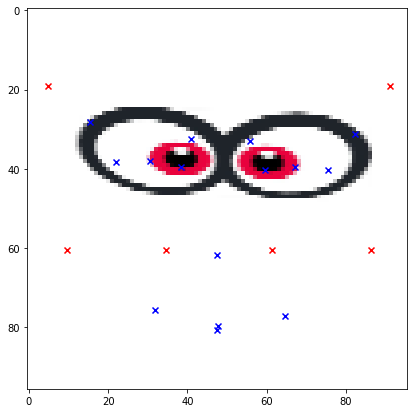

In [65]:
new_eyes_img = cv2.warpAffine(img_eyes, trans_exp3, (96, 96))
plt.figure(figsize=(7, 7))
plt.imshow(new_eyes_img, cmap='gray')
plt.scatter(eyes_xs, eyes_ys, marker='x', color='red')
plt.scatter(xs, ys, marker='x', color='blue')
plt.show()

In [66]:
training_im = []
for i in range(len(x_train)):
    uint8 = x_train[i].reshape(96,96).astype('uint8')
    uint8_color = cv2.cvtColor(uint8,cv2.COLOR_GRAY2RGBA)
    training_im.append(uint8_color)

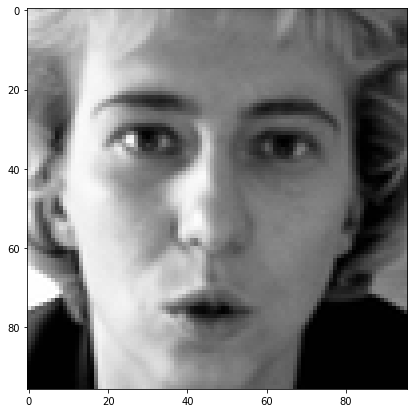

In [67]:
plt.figure(figsize=(7, 7))
plt.imshow(training_im[1])

In [68]:
#Glasses Filter
for i in range(len(training_im)):
    # normalize alpha channels
    background = training_im[i][:,:,3] / 255.0
    foreground = new_eyes_img[:,:,3] / 255.0
    # set adjusted colors
    for color in range(0, 3):
        training_im[i][:,:,color] = foreground * new_eyes_img[:,:,color] + \
            background * training_im[i][:,:,color] * (1 - foreground)
    # set adjusted alpha and denormalize back to 0-255
    training_im[i][:,:,3] = (1 - (1 - foreground) * (1 - background)) * 255

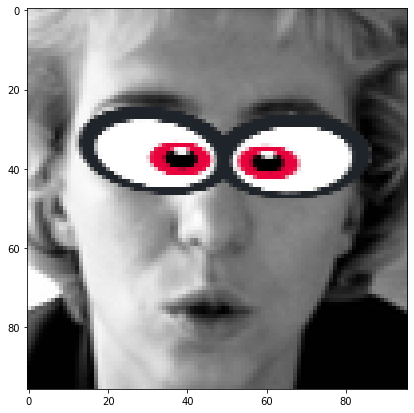

In [69]:
plt.figure(figsize=(7, 7))
plt.imshow(training_im[1])

In [70]:
#Nose Filter
for i in range(len(training_im)):
    # normalize alpha channels
    background = training_im[i][:,:,3] / 255.0
    foreground = new_nose2_img[:,:,3] / 255.0
    # set adjusted colors
    for color in range(0, 3):
        training_im[i][:,:,color] = foreground * new_nose2_img[:,:,color] + \
            background * training_im[i][:,:,color] * (1 - foreground)
    # set adjusted alpha and denormalize back to 0-255
    training_im[i][:,:,3] = (1 - (1 - foreground) * (1 - background)) * 255

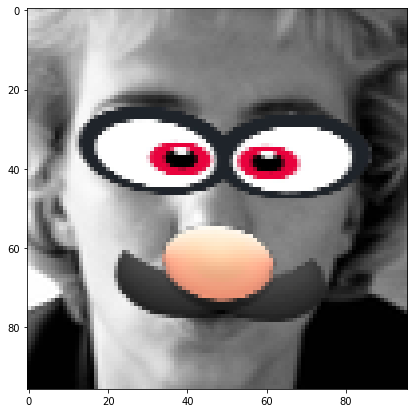

In [71]:
plt.figure(figsize=(7, 7))
plt.imshow(training_im[1])